The velodyne LIDAR data has some neat properties I am hoping to exploit with this algorithm. The dat is:

1. All indoors, so points are in straight lines where the walls are. 
2. A sparse array of samples, not a dense matrix, so using traditional computer vision techniques often requires rendering the sparse array onto a dense matrix of pixel data. 

First, lets load a single frame of data.

In [1]:
import rosbag, sensor_msgs.point_cloud2
import numpy as np
from matplotlib import pyplot as plt 
from copy import deepcopy
from random import choice as rand_choice
from scipy.stats import norm

bag = rosbag.Bag('data_2020-06-10-10-24-18.bag')

topic, msg, time = next(bag.read_messages(topics=["/velodyne_points"]))
allpoints = list(sensor_msgs.point_cloud2.read_points(msg))
len(allpoints)

28914

30,000 points is way too many points, and each point is five dimensional. Let's take a 2D subset. 

In [2]:
def decimate(iterable, p=.1):
    new = []
    for i in iterable:
        if np.random.rand() < p:
            new.append(i)
    return new

def take_x_and_y(points):
    #the velodyne point data is five dimensional? 
    #x y z ?? ??
    #we only want x and y so the other dimensions don't
    #interfere with math functions, and so we need less memory
    #for storage
    return [[p[0], p[1]] for p in points]

points = decimate(allpoints, .3)
points = take_x_and_y(points)
len(points)

8689

Let's see what this looks like. 

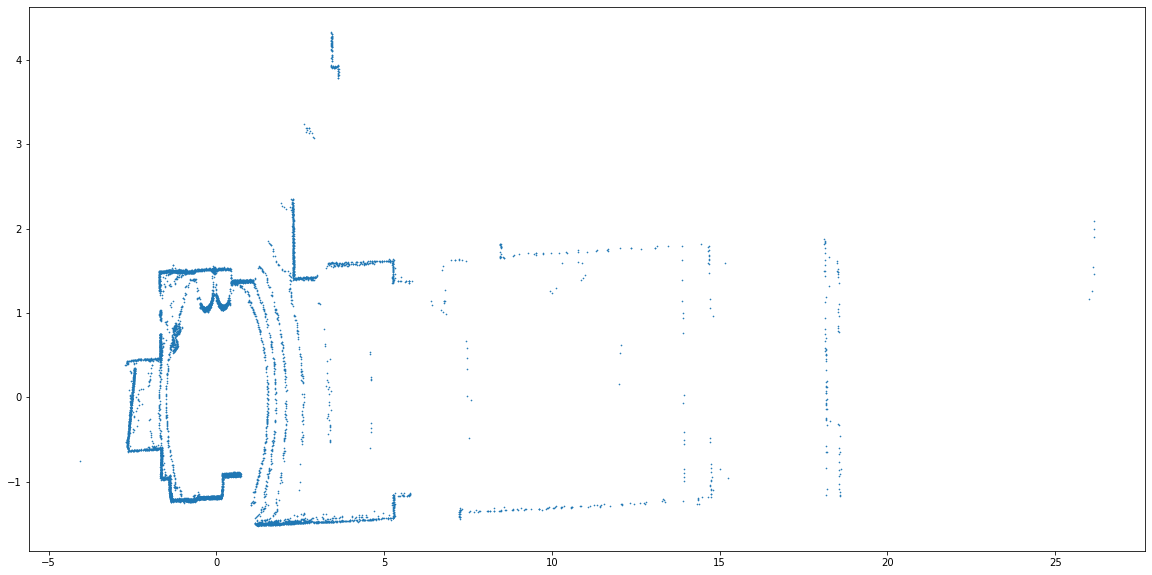

In [19]:
plt.rcParams['figure.figsize'] = [20, 10]
def graph(points, s=.4):
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    plt.scatter(x, y, s=s)
    
graph(points)

There are too many outliers. Let's enforce that every point has some neighbors. 

In [4]:
from scipy import spatial 
import time

def min_density_selection(points, n_neighbors, distance):
    """construct a new pointcloud only containing points with at 
    least n_neighbors within distance.
    
    returns a numpy array of selected points"""
    tree = spatial.KDTree(points)
    #kdtree does not copy the points, it just makes an index over them 
    selected_points = []
    for point in points:
        neighbors = tree.query_ball_point([point], distance)[0]
        if len(neighbors) >= n_neighbors:
            selected_points.append(point)

    return np.array(selected_points)

In [5]:
st = time.time()
dense_points = min_density_selection(points, 4, .05)
time.time() - st

12.438916683197021

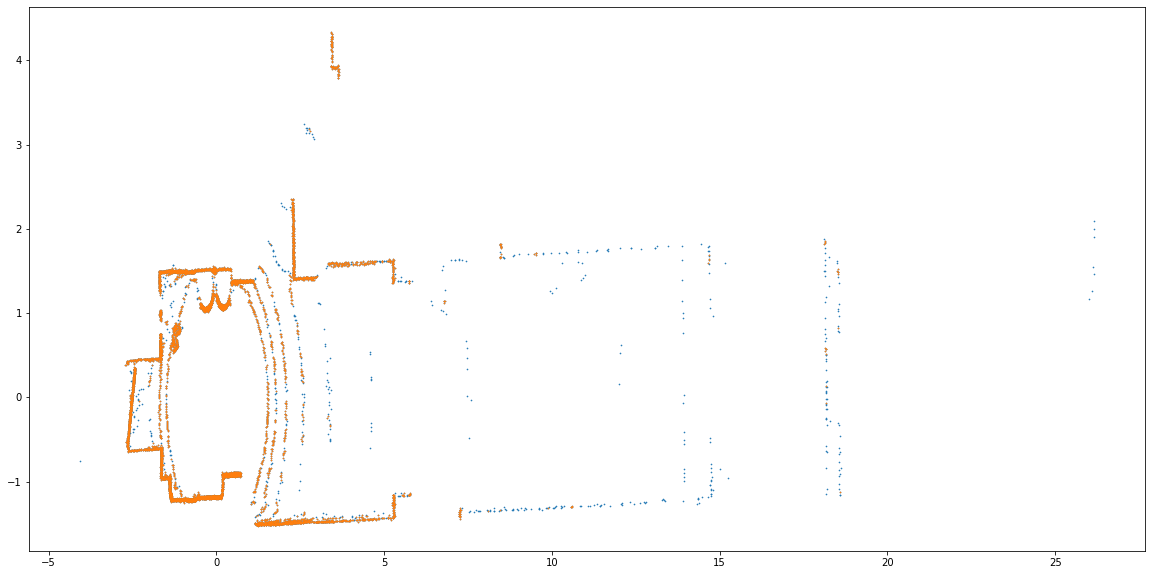

In [6]:
graph(points)
graph(dense_points)

We got rid of outliers, but we also got rid of a lot of the walls. Let's try something else. 

In [7]:
from sklearn.cluster import MiniBatchKMeans
def cluster_centroids(x, n_clusters):
    """fit kmeans clusters then return the average of the clusters"""
    clusterer = MiniBatchKMeans(n_clusters=n_clusters)
    clusterer = clusterer.fit(x)
    #FIXME: there's no reason to do this, sklearn has a variable for 
    #the cluster centers
    groups = {}
    for i, label in enumerate(clusterer.labels_):
        if not label in groups:
            groups[label] = []
        groups[label].append(x[i])
    
    for group in groups:
        groups[group] = np.mean(groups[group], axis=0).tolist()

    return np.array(list(groups.values()))

In [8]:
st = time.time()
centroid_points = cluster_centroids(points, 300)
time.time() - st

0.2617228031158447

In [9]:
st = time.time()
dense_centroid_points = cluster_centroids(dense_points, 300)
time.time() - st

0.5435972213745117

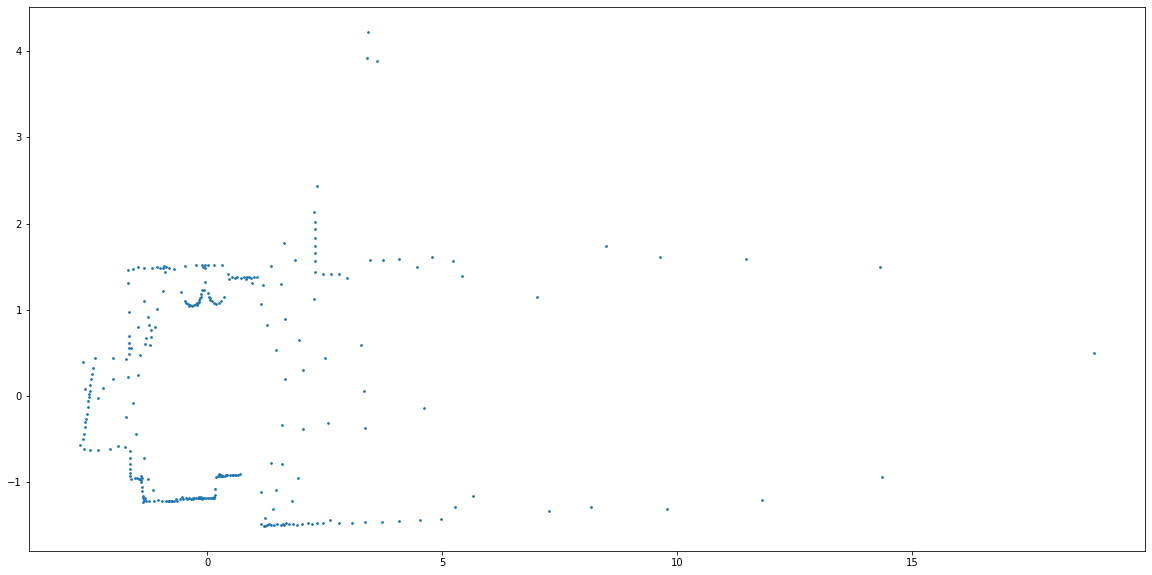

In [10]:
#graph(points)
graph(centroid_points, 3)

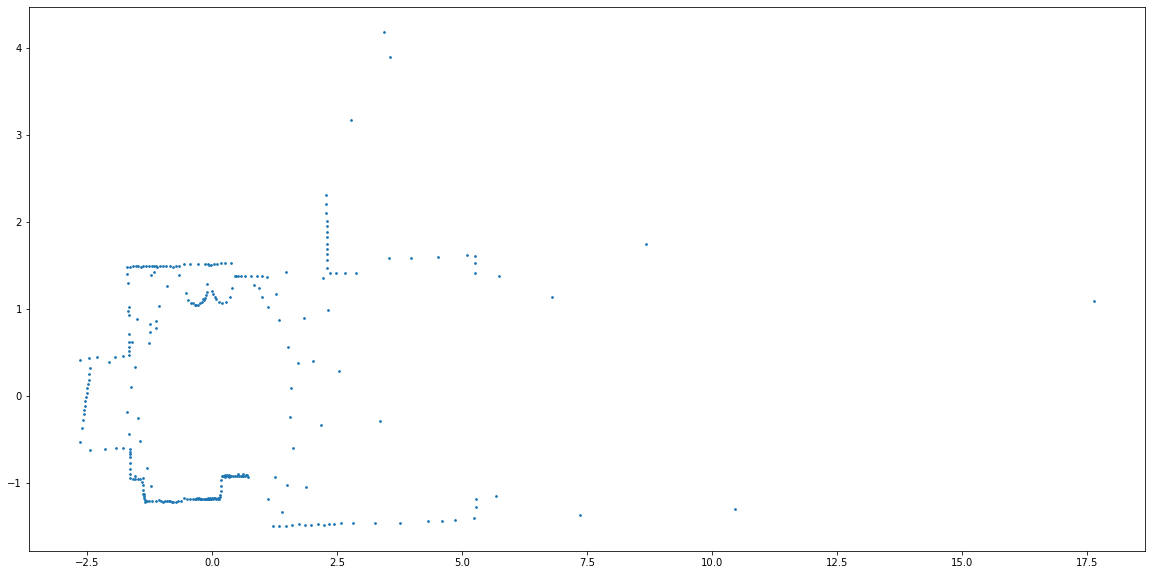

In [11]:
#graph(points)
graph(dense_centroid_points, 3)

This method is fast, but seems to have trouble with noise and outliers. Running the density scan beforehand improves it, but the density scan is currently very slow. That should be possible to dramatically speed up though, since running kmeans to convergence only takes .3 seconds. What if we run the cluster centroid function, then the density scan? 

/home/anthony/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/anthony/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/anthony/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  cluster_centers = _init_centroids(


2.6095786094665527


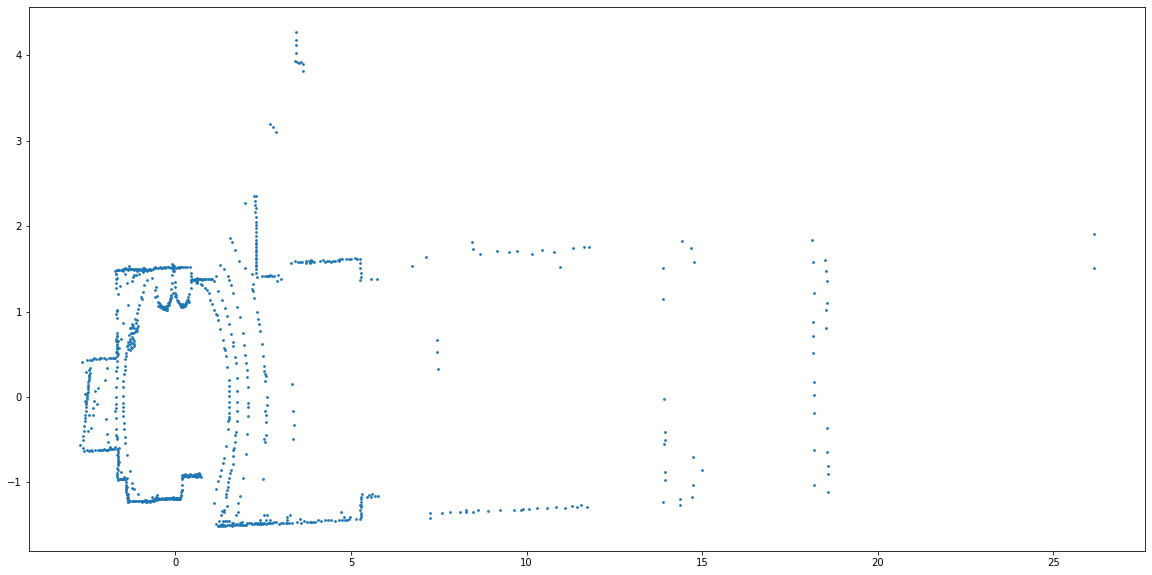

In [12]:
st = time.time()
test_points = cluster_centroids(points, 1000)
good_points = min_density_selection(test_points, 3, .5)
print(time.time() - st)

#graph(test_points, 3)
graph(good_points, 3)

This looks pretty good, but I did tune every parameter to give the best possible results. I have no idea how robust this method is for other frames. 

Next, we can use our much smaller collection of points to try and fit lines where the walls would be. Lines are represented by an (x, y, theta) triplet. A line representing a wall will pass through at least one point. This means that, to fit a wall, we can select a point from our pointcloud then run a one dimensional search to find the best theta. 

First, let's make a line object with some useful methods.

In [13]:
def line_point_distance(line, point):
    """Calculate minimum euclidean distance from line to point"""
    #I got the formula for finding how close a point is to a line from wikipedia. It requires
    #two points from each line. 
    x0, y0 = point[0], point[1]
    x1, y1 = (line.params["x"], line.params["y"])
    x2, y2 = (line.params["x"] + np.cos(line.params["theta"]), line.params["y"] + np.sin(line.params["theta"]))
    return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)/np.sqrt((y2-y1)**2 + (x2-x1)**2)

class Line(object):
    """Represent a line and provide methods of doing math involving other lines. """

    def __init__(self, x, y, theta, distance_scale=.2):
        """accept x, y, and theta, and store them under a self.params dictionary. """
        self.params = {"x": x, "y": y, "theta": theta}
        self.distance_scale = distance_scale
 
    def score(self, pointcloud):
        """we want score to reflect the summation of the likelihood that a wall occupying this space would 
        trigger a recorded point for each point in the pointcloud.
        This method is intended to reflect the amount of points that are explained by a wall occupying this 
        position. """
        total = 0
        for point in pointcloud:
            chance = self._likelihood_of_being_cause_of_point(point)
            total += chance 
        self.most_recent_score = total
        return total 

    def _likelihood_of_being_cause_of_point(self, point):
        #LIDAR scans in cylindrical dimensions, with a standard deviation along each 
        #dimension. However, we do a lot of pointcloud cleaning before this function 
        #is called, so let's just pretend its a cartesian gaussian. 
        
        #get euclidean distance to point
        distance = line_point_distance(self, point)
        
        #convert distance to the likelihood this wall would cause this point
        #FIXME: distance should be scaled based on the standard deviation of the points from the
        #true wall location. I randomly picked the value 2. 
        chance = 1 - norm.cdf(distance*self.distance_scale)
        return chance   

    def _theta_subtract(self, theta):
        """Minimum possible radian value of the roation between the passed angles. """
        thetas  = sorted([self.params["theta"], theta])
        while thetas[0] <= thetas[1]:
            prev_theta = thetas[0]
            thetas[0] += np.pi * 2
        difference_a = prev_theta - thetas[1]
        difference_b = thetas[0] - thetas[1]
        return min(difference_a, difference_b)

When we fit a line, we care more about the local structure than the global structure. We need a class to associate a line with a pointcloud subset. 

In [14]:
class LineCaster(object):
    def __init__(self, pointcloud, centerpoint=None):
        """A linecaster holds a pointcloud, line centerpoint, 
        and line angle. The line angle is chosen to maximize the 
        amount of points the line explains. """
        self.pointcloud = pointcloud
        if centerpoint is None:
            centerpoint = rand_choice(pointcloud)
        self.centerpoint = centerpoint
        
        #there's probably a way to do this analytically or with autodiff, 
        #but a one dimensional search is fast already
        self._try_pointing_at_every_point()

    def _try_pointing_at_every_point(self, min_theta_resolution=.05):
        """Local search method of collection of angles that point at 
        points in the pointcloud. """
        #because we did the kmeans centroid clustering, 
        #a lot of our points are in straight lines. 
        #walls will pass through all those points, 
        #so when searching for the best theta we can 
        #set theta based on other points. 
        tried_thetas = []
        best_found_theta = 0
        best_found_score = 0

        #create line object 
        self.line = Line(self.centerpoint[0], self.centerpoint[1], 0)

        #attempt pointing the line at every point in the self pointcloud
        for point in self.pointcloud:
            #skip iteration if point is the centerpoint
            if np.allclose(point, self.centerpoint):
                continue 
            
            #calculate angle between points
            theta = np.arctan2(point[1] - self.centerpoint[1], point[0] - self.centerpoint[0])
            
            #if the theta is too similar to one that has been tried, skip iteration 
            if tried_thetas and min([np.abs(t-theta) for t in tried_thetas]) < min_theta_resolution:
                continue 
            tried_thetas.append(theta) #record this angle as having been tried
            
            #test this line against the best found line 
            self.line.params["theta"] = theta 
            score = self.line.score(self.pointcloud)
            if score > best_found_score:
                best_found_score = score 
                best_found_theta = theta 
        self.score = best_found_score
        self.line.params["theta"] = best_found_theta

Now, we want to:

1. Init a population of n linecasters, each optimized for their local pointcloud
2. Remove duplicate lines 
3. Not every line represents a wall, since not all the points do and our fitting algorithm isn't perfect. We want a subset of lines that we are most certain are walls. We don't want points to increase the scores of more than one line. So, we need to select lines and remove explained-by-the-wall points from the pointcloud in an order that maximizes: 
    - total score? 
    - total scores squared? 
    - minimize unexplained points? 
    

In [15]:
class Pointcloud(object):
    def __init__(self, points, local_neighborhood_radius):
        self.points = points 
        
        self.kdtree = {}
        self.kdtree_sync = False
        self.local_neighborhood_radius = local_neighborhood_radius
        
    def segment_over_line(self, line):
        explained = []
        unexplained = []
        for point in self.points:
            distance = line_point_distance(line, point)
            if distance < self.local_neighborhood_radius: 
                explained.append(point)
            else:
                unexplained.append(point)
        return explained, unexplained
    
    def query_ball_point(self, point):
        #ensure kdtree is up to date 
        if not self.kdtree_sync:
            self.kdtree = spatial.KDTree(self.points)
            self.kdtree_sync = True
        
        close_point_indexes = self.kdtree.query_ball_point([point], self.local_neighborhood_radius)[0]
        return [self.points[i] for i in close_point_indexes]

class LCPopulation(object):
    def __init__(self, points, n_lines, local_neighborhood_radius=.4):
        self.pointcloud = Pointcloud(points, local_neighborhood_radius) 
        self.linecasters = []
        self.local_neighborhood_radius = local_neighborhood_radius
        

        #now fill in the population of optimized lines
        for _ in range(n_lines):
            #select a point the line will pass through
            point = rand_choice(points)
            
            #get the points close to this point 
            close_points = self.pointcloud.query_ball_point(point)
            
            self.linecasters.append(LineCaster(close_points, point))

    def calc_best_order(self, n_lines):
        """Find the ordered subset of the collection of lines that gives the greatest 
        total of the squares of  the scores of the selected n lines. """
        #this is where a metaheuristic should be I guess 
        #lets see how well a simple heuristic works first 
        selected_LCs = []
        
        #we need a copy of the pointcloud we can strip data from 
        pointcloud = deepcopy(self.pointcloud)
        lcs = deepcopy(self.linecasters) #and these 
        
        for x in range(n_lines):
            #check that every point hasn't been explained
            if not len(pointcloud.points):
                break 
                
            #update scores for new pointcloud
            self._rescore(lcs, pointcloud)
            
            #obtain best lc
            lcs.sort(key=lambda lc: lc.score)
            selected_lc = lcs[-1]
            selected_LCs.append(selected_lc)
            del lcs[-1]
            
            #pluck the explained points from the population
            explained, unexplained = pointcloud.segment_over_line(selected_lc.line)
            pointcloud = Pointcloud(unexplained, self.local_neighborhood_radius)
            
        return selected_LCs
            
            
    def _rescore(self, linecasters, pointcloud):
        for lc in linecasters:
            lc.line.score(pointcloud.points)


In [23]:
lf = LCPopulation(good_points, 200, .6)

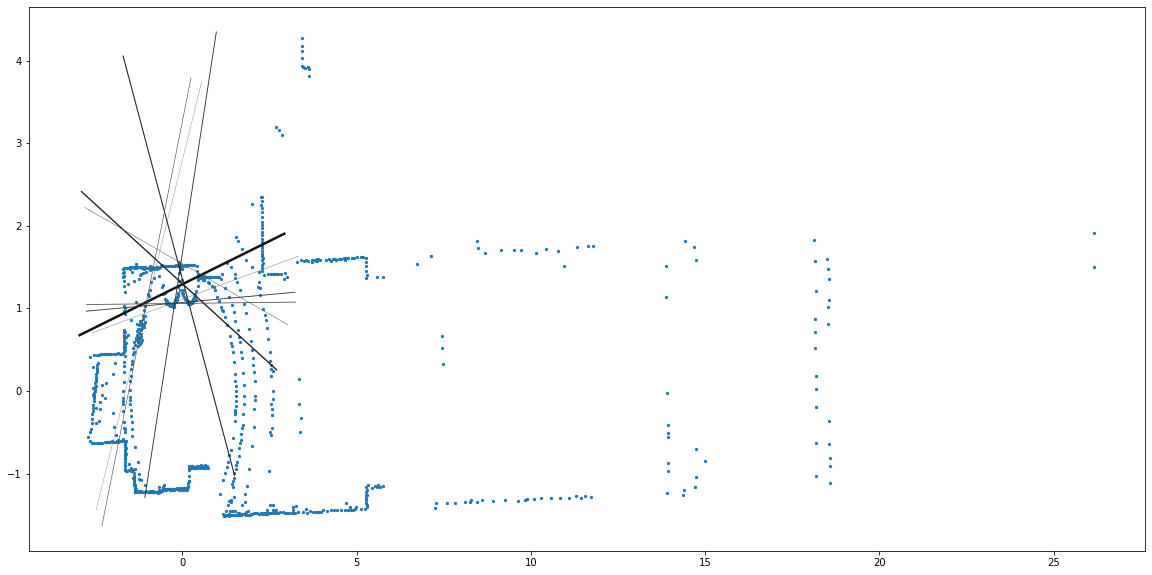

In [24]:
best_lines = lf.calc_best_order(10) #this is really really slow but its easy to fix
def graph_line(line, plt):
    """Graph a line with a width and color dependent on its score"""
    point_a_x = line.params["x"] + (np.cos(line.params["theta"]) * 3)
    point_a_y = line.params["y"] + (np.sin(line.params["theta"]) * 3)
    
    point_b_x = line.params["x"] + (np.cos(line.params["theta"]) * -3)
    point_b_y = line.params["y"] + (np.sin(line.params["theta"]) * -3)

    plt.plot([point_a_x, point_b_x], [point_a_y, point_b_y], color=str(255/line.most_recent_score/10), linewidth=line.most_recent_score/150)

plt.clf()
for lc in best_lines:
    graph_line(lc.line, plt)
    
graph(good_points, 5)
plt.show()

It looks like the simple heuristic of selecting the most explanatory line every time is too greedy. It is preoccupied with the corners to the point it ignores the walls. I think a better metaheuristic selection should fix this. Reducing the tolerance for how close a point needs to be to a line should also reduce the bias towards corners, but would require a more accurate optimization method for the angle of the lines. Perhaps a repeated point assignment followed by ODR regression refitting, kind of like how kmeans works. 

I am planning on implementing a genetic algorithm for the line selection metaheuristic. Scoring lines can be drastically sped up by precomputing the distance matrix between lines and points. 